# Things are getting deep and convoluted
The one trick that we haven't used yet is the use of [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) layers. So far, we have fed the board state into the Neural Network as a 1d array. This makes it hard for the Neural Network to exploit the inherently 2D nature of the board though.

CNN layers can slide a 2D window over the board-state and thus learn about 2 dimensional patterns:

<table width=100%> <tr> <td>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="250" />
    </td><td>
<img src="https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc." width="200" />
    </td></tr>
<tr> <td>
    [Source: Wikiepedia](https://en.wikipedia.org/wiki/File:Conv_layer.png)
    </td><td>
    [Source: Daphne Cornelisse "An intuitive guide to Convolutional Neural Networks"](https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)

</table>

And indeed, many contemporary NN approaches to learning how to play board games use CNN layers as part of their topology. The most prominent exmaple being [Alpha Go](https://deepmind.com/blog/alphago-zero-learning-scratch/) by Deep Mind. If it's good enough for them, it should be good enough for us. We'll take the NN from our previous part and simply pop a few CNN layers on top:

```Python
def build_graph(self, name: str):
    """
    Builds a new TensorFlow graph with scope `name`
    :param name: The scope for the graph. Needs to be unique for the session.
    """
    with tf.variable_scope(name):
        [...]
        net = self.input_positions

        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)
        net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)

        net = tf.layers.flatten(net)

        net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.relu)

```


We'll also have to change our input state encoding to be 3 2D planes, one plane each for crosses, naughts, and empty fields.

```Python
def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
    res = np.array([(state == self.side).astype(int),
                    (state == Board.other_side(self.side)).astype(int),
                    (state == EMPTY).astype(int)])
    res = res.reshape(3, 3, 3)
    res = np.transpose(res, [1, 2, 0])
```
The transpose at the end is necessary to switch some axis around. Seems like TensorFlow likes it better this way - or in the case of running on a CPU actually insists.

By adding the conv2d layers we now have a Convolutinal Neural Network. Since this also cinreases the depth of our network, we can now call it a Deep Network as well.


# Some other changes while we are at it
There are two more smaller changes we make at this stage. We add regularization loss and [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) support.

## Regularization Loss
One problem Neural Networks can face is that weights get increasingly large. This in turn can cause numerical instabilities. A straight forward approach to dealing with this, is to define a loss based on how large the weights are and add this to the total loss function of the Neural Network. This gives the training step an incentive to keep weights small. 

We need to balance the regularization loss with the rest of the loss function however to avoid the Neural Network optimizing the regularization loss at the expense of a higher loss in our Q function. We don't want this.

In the code this means, we add a `kernel_regularizer` to every layer, e.g. like this:

```Python
return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                       kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                       kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                       name=name)
```

We then add the regularization loss to the total loss:

```Python
self.reg_losses = tf.identity(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, scope=name),
                              name="reg_losses")
reg_loss = self.beta * tf.reduce_mean(self.reg_losses)

self.total_loss = tf.add(self.loss, reg_loss, name="total_loss")
```
with `self.beta` being a factor smaller than 1 to scale down `reg_loss` and prevent it from dominating the optimization process.

## TensorBoard support
The 2nd change we are making is to add support for TensorBoard. TensorBoard is a dashboard that comes with TensorFlow the helps visualizing NN graphs as well as all kinds of metrics around training and performance.

So far, the only metric we looked at as the win-loss-draw ratio out NN achieved. By using TensorBoard we might be able to get some additional insights.

In order to do this, we need to create a summary writer, write to it, and in the end close it:

```Python
sess = TFSessionManager.get_session()
writer = tf.summary.FileWriter(TENSORLOG_DIR, sess.graph)
[...]
writer.close()
```

To capture the actual metrics, we add the approptiate lines when building graph;
```Python
def build_graph(self, name: str):
    """
    Builds a new TensorFlow graph with scope `name`
    :param name: The scope for the graph. Needs to be unique for the session.
    """
    with tf.variable_scope(name):
        [...]
        self.q = tf.reduce_sum(tf.multiply(self.q_values, self.actions_onehot), axis=1, name="selected_action_q")

        tf.summary.histogram("Action Q values", self.q)

        [...]
        self.loss = tf.reduce_mean(self.td_error, name="q_loss")

        tf.summary.scalar("Q Loss", self.loss)
        [...]
        reg_loss = self.beta * tf.reduce_mean(self.reg_losses)
        tf.summary.scalar("Regularization loss", reg_loss)

        self.merge = tf.summary.merge_all()

        [...]

```

This creates a Tensor `self.merge` which we can run with the training step:

```Python
def final_result(self, result: GameResult):
    [...]
    
    summary, _ = TFSN.get_session().run([self.q_net.merge, self.q_net.train_step], feed_dict=[...])
    
    [...]
    
    if self.writer is not None:
        self.writer.add_summary(summary, self.game_counter)
        summary = tf.Summary(value=[tf.Summary.Value(tag='Random Move Probability',
                                                     simple_value=self.random_move_prob)])
        self.writer.add_summary(summary, self.game_counter)
```

## Some changes in hyper parameters

I have also changed some of the hyper-parameter:

```Python
def __init__(self, name: str, reward_discount: float = 0.99, win_value: float = 10.0, draw_value: float = 0.0,
                 loss_value: float = -10.0, learning_rate: float = 0.01, training: bool = True,
                 random_move_prob: float = 0.9999, random_move_decrease: float = 0.9997, batch_size=60,
                 pre_training_games: int = 500, tau: float = 0.001):
```

In particular, we do random moves for longer, discount the reward less, and changed the win and loss rewards by a factor of 10.

# Let's play

Time to play some games. The player is implemented in [DeepExpDoubleDuelQPlayer](./tic_tac_toe/DeepExpDoubleDuelQPlayer.py).

A note of warning: CNN performance really improves a lot by using a GPU. If you don't have a supported GPU and the GPU version of TensorFlow installed, you will need some patience.

To start with, as a sanity check, going first against the RandomPlayer:

INFO:tensorflow:Summary name Action Q values is illegal; using Action_Q_values instead.
INFO:tensorflow:Summary name Q Loss is illegal; using Q_Loss instead.
INFO:tensorflow:Summary name Regularization loss is illegal; using Regularization_loss instead.
INFO:tensorflow:Summary name Action Q values is illegal; using Action_Q_values instead.
INFO:tensorflow:Summary name Q Loss is illegal; using Q_Loss instead.
INFO:tensorflow:Summary name Regularization loss is illegal; using Regularization_loss instead.
After 100 game we have draws: 13, Player 1 wins: 64, and Player 2 wins: 23.
Which gives percentages of draws: 13.00%, Player 1 wins: 64.00%, and Player 2 wins:  23.00%
After 100 game we have draws: 8, Player 1 wins: 62, and Player 2 wins: 30.
Which gives percentages of draws: 8.00%, Player 1 wins: 62.00%, and Player 2 wins:  30.00%
After 100 game we have draws: 12, Player 1 wins: 57, and Player 2 wins: 31.
Which gives percentages of draws: 12.00%, Player 1 wins: 57.00%, and Player 2 wins

After 100 game we have draws: 3, Player 1 wins: 95, and Player 2 wins: 2.
Which gives percentages of draws: 3.00%, Player 1 wins: 95.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 6, Player 1 wins: 91, and Player 2 wins: 3.
Which gives percentages of draws: 6.00%, Player 1 wins: 91.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 4, Player 1 wins: 92, and Player 2 wins: 4.
Which gives percentages of draws: 4.00%, Player 1 wins: 92.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 6, Player 1 wins: 91, and Player 2 wins: 3.
Which gives percentages of draws: 6.00%, Player 1 wins: 91.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 3, Player 1 wins: 94, and Player 2 wins: 3.
Which gives percentages of draws: 3.00%, Player 1 wins: 94.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 7, Player 1 wins: 87, and Player 2 wins: 6.
Which gives percentages of draws: 7.00%, Player 1 wins: 87.00%, and Player 2 wins:  6.00%
After 100 game w

After 100 game we have draws: 2, Player 1 wins: 95, and Player 2 wins: 3.
Which gives percentages of draws: 2.00%, Player 1 wins: 95.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 1, Player 1 wins: 97, and Player 2 wins: 2.
Which gives percentages of draws: 1.00%, Player 1 wins: 97.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 1, Player 1 wins: 98, and Player 2 wins: 1.
Which gives percentages of draws: 1.00%, Player 1 wins: 98.00%, and Player 2 wins:  1.00%


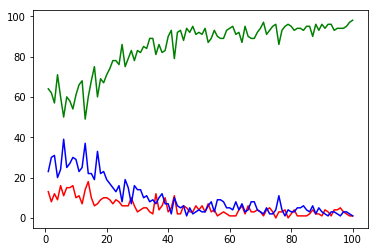

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.TFSessionManager import TFSessionManager
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.DeepExpDoubleDuelQPlayer import DeepExpDoubleDuelQPlayer

tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Im getting some really solid results here. Sometime it even finds a policy that gives it 0% losses while still winning >90% of the games.

Let's try going second:

In [ ]:
tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

INFO:tensorflow:Summary name Action Q values is illegal; using Action_Q_values instead.
INFO:tensorflow:Summary name Q Loss is illegal; using Q_Loss instead.
INFO:tensorflow:Summary name Regularization loss is illegal; using Regularization_loss instead.
INFO:tensorflow:Summary name Action Q values is illegal; using Action_Q_values instead.
INFO:tensorflow:Summary name Q Loss is illegal; using Q_Loss instead.
INFO:tensorflow:Summary name Regularization loss is illegal; using Regularization_loss instead.
After 100 game we have draws: 18, Player 1 wins: 48, and Player 2 wins: 34.
Which gives percentages of draws: 18.00%, Player 1 wins: 48.00%, and Player 2 wins:  34.00%
After 100 game we have draws: 13, Player 1 wins: 62, and Player 2 wins: 25.
Which gives percentages of draws: 13.00%, Player 1 wins: 62.00%, and Player 2 wins:  25.00%
After 100 game we have draws: 8, Player 1 wins: 63, and Player 2 wins: 29.
Which gives percentages of draws: 8.00%, Player 1 wins: 63.00%, and Player 2 wins

After 100 game we have draws: 9, Player 1 wins: 22, and Player 2 wins: 69.
Which gives percentages of draws: 9.00%, Player 1 wins: 22.00%, and Player 2 wins:  69.00%
After 100 game we have draws: 10, Player 1 wins: 20, and Player 2 wins: 70.
Which gives percentages of draws: 10.00%, Player 1 wins: 20.00%, and Player 2 wins:  70.00%
After 100 game we have draws: 9, Player 1 wins: 17, and Player 2 wins: 74.
Which gives percentages of draws: 9.00%, Player 1 wins: 17.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 9, Player 1 wins: 22, and Player 2 wins: 69.
Which gives percentages of draws: 9.00%, Player 1 wins: 22.00%, and Player 2 wins:  69.00%
After 100 game we have draws: 9, Player 1 wins: 24, and Player 2 wins: 67.
Which gives percentages of draws: 9.00%, Player 1 wins: 24.00%, and Player 2 wins:  67.00%
After 100 game we have draws: 14, Player 1 wins: 23, and Player 2 wins: 63.
Which gives percentages of draws: 14.00%, Player 1 wins: 23.00%, and Player 2 wins:  63.00%
